In [1]:
%load_ext jupyter_black

### Your very own neural network

In this notebook, we're going to build a neural network using naught but pure numpy and your willpower. It's going to be fun, I promise!

![img](https://github.com/yandexdataschool/Practical_DL/blob/fall24/week01_backprop/frank.png?raw=1)

In [2]:
# if running in colab, uncomment this:
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/23f74b181e0c0be9f27852de228d1b69b9a08124/week01_backprop/util.py -O util.py
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/23f74b181e0c0be9f27852de228d1b69b9a08124/week01_backprop/mnist.py -O mnist.py
from __future__ import print_function
import numpy as np

np.random.seed(42)

Here goes our main class: a layer that can .forward() and .backward().

In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """

    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass

    def forward(self, X):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return X

    def backward(self, X, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = X.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input)  # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, X):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0.0, X)

    def backward(self, X, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = X > 0.0
        return grad_output * relu_grad

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= X \cdot W + \vec b $$

Where
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs]
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [5]:
class Dense(Layer):
    def __init__(
        self,
        input_units,
        output_units,
        lr: float = 0.001,
        beta1: float = 0.9,
        beta2: float = 0.999,
        tol: float = 1e-8,
    ):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        Default values from the initial Adam optimizer article were used.

        Args:
            lr: learning rate (default 0.001)
            beta1: momentum decay rate (default 0.9)
            beta2: variance decay rate (default 0.999)
            tol: tolerance (default 1e-8)
        """
        self.bias_correction = lambda x, coef: x / (1.0 - coef)

        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta1_t = beta1
        self.beta2_t = beta2
        self.tol = tol

        # initialize weights with small random numbers. We use normal initialization,
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.momentum1 = np.zeros((input_units, output_units))
        self.momentum2 = np.zeros((input_units, output_units))
        self.biases = np.zeros(output_units)
        self.momentum1_bias = np.zeros(output_units)
        self.momentum2_bias = np.zeros(output_units)

    def forward(self, X):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return X @ self.weights + self.biases

    def backward(self, X, grad_output):
        """
        Perform backpropagation step: compute the gradient of the layer's outputs w.r.t. to its inputs and
        update the weights and biases of the layer itself using Adam optimizer.

        Args:
            X: input data [batch_size, n_features]
            grad_output: gradient of the loss function at X [batch_size, output_units]

        Returns:
            grad_input: gradient of the layer's outputs w.r.t. to its inputs
        """
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output @ self.weights.T

        # compute gradient w.r.t. weights and biases
        # [input_units, output_units]
        grad_weights = X.T @ grad_output
        # [output_units]
        grad_biases = grad_output.sum(axis=0)

        assert (
            grad_weights.shape == self.weights.shape
            and grad_biases.shape == self.biases.shape
        )

        # Here we perform a stochastic gradient descent step.
        # weights:
        self.momentum1 = self.beta1 * self.momentum1 + (1.0 - self.beta1) * grad_weights
        unbiased_momentum1 = self.momentum1 / (1.0 - self.beta1_t)
        self.momentum2 = self.beta2 * self.momentum2 + (1.0 - self.beta2) * (
            grad_weights**2
        )
        unbiased_momentum2 = self.momentum2 / (1.0 - self.beta2_t)
        self.weights = self.weights - self.lr * unbiased_momentum1 / (
            np.sqrt(unbiased_momentum2) + self.tol
        )
        # biases:
        self.momentum1_bias = (
            self.beta1 * self.momentum1_bias + (1.0 - self.beta1) * grad_biases
        )
        unbiased_momentum1_bias = self.momentum1_bias / (1.0 - self.beta1_t)
        self.momentum2_bias = self.beta2 * self.momentum2_bias + (1.0 - self.beta2) * (
            grad_biases**2
        )
        unbiased_momentum2_bias = self.momentum2_bias / (1.0 - self.beta2_t)
        self.biases = self.biases - self.lr * unbiased_momentum1_bias / (
            np.sqrt(unbiased_momentum2_bias) + self.tol
        )

        self.beta1_t *= self.beta1
        self.beta2_t *= self.beta2

        return grad_input

In [6]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1, (
    "The initial weights must have zero mean and small variance. "
    "If you know what you're doing, remove this assertion."
)
assert (
    -0.05 < l.biases.mean() < 0.05
), "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3, 4)

x = np.linspace(-1, 1, 2 * 3).reshape([2, 3])
l.weights = np.linspace(-1, 1, 3 * 4).reshape([3, 4])
l.biases = np.linspace(-1, 1, 4)

assert np.allclose(
    l.forward(x),
    np.array(
        [
            [0.07272727, 0.41212121, 0.75151515, 1.09090909],
            [-0.90909091, 0.08484848, 1.07878788, 2.07272727],
        ]
    ),
)
print("Well done!")

Well done!


In [7]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
l = Dense(32, 64, learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(), x)
grads = l.backward(x, np.ones([10, 64]))

assert np.allclose(
    grads, numeric_grads, rtol=1e-3, atol=0
), "input gradient does not match numeric grad"
print("Well done!")

TypeError: Dense.__init__() got an unexpected keyword argument 'learning_rate'

In [ ]:
# test gradients w.r.t. params
def compute_out_given_wb(w, b):
    l = Dense(32, 64, learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
    return l.forward(x)


def compute_grad_by_params(w, b):
    l = Dense(32, 64, learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
    l.backward(x, np.ones([10, 64]) / 10.0)
    return w - l.weights, b - l.biases


w, b = np.random.randn(32, 64), np.linspace(-1, 1, 64)

numeric_dw = eval_numerical_gradient(
    lambda w: compute_out_given_wb(w, b).mean(0).sum(), w
)
numeric_db = eval_numerical_gradient(
    lambda b: compute_out_given_wb(w, b).mean(0).sum(), b
)
grad_w, grad_b = compute_grad_by_params(w, b)

assert np.allclose(
    numeric_dw, grad_w, rtol=1e-3, atol=0
), "weight gradient does not match numeric weight gradient"
assert np.allclose(
    numeric_db, grad_b, rtol=1e-3, atol=0
), "weight gradient does not match numeric weight gradient"
print("Well done!")

In [8]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]

    xentropy = -logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy


def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)

    return (-ones_for_answers + softmax) / logits.shape[0]

### Testing the network

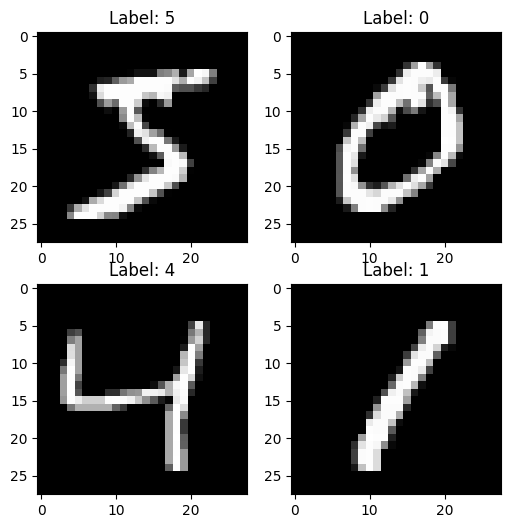

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

from mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap="gray");

In [10]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    Make sure last activation corresponds to network logits.
    """
    activations = []

    for idx, layer in enumerate(network):
        if idx == 0:
            activations.append(layer.forward(X))
        else:
            activations.append(layer.forward(activations[idx - 1]))

    assert len(activations) == len(network)
    return activations


def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

### Backprop

You can now define the backpropagation step for the neural network. Please read the docstring.

In [11]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first,
    propagating the gradient of input to previous layers.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    for idx, layer in reversed(list(enumerate(network))):
        if idx == (len(network) - 1):
            grad = layer.backward(layer_activations[idx - 1], loss_grad)
        elif idx > 0:
            grad = layer.backward(layer_activations[idx - 1], grad)
        else:
            grad = layer.backward(X, grad)

    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [12]:
from tqdm import trange
from IPython.display import clear_output
import time


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx : start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


def test_NN(network: list[Layer], epochs: int = 25):

    train_log = []
    val_log = []
    train_times = []

    for epoch_id in range(epochs):

        t0 = time.time()
        for x_batch, y_batch in iterate_minibatches(
            X_train, y_train, batchsize=32, shuffle=True
        ):
            train(network, x_batch, y_batch)
        t1 = time.time()

        train_times += [t1 - t0]

        train_log.append(np.mean(predict(network, X_train) == y_train))
        val_log.append(np.mean(predict(network, X_val) == y_val))

        clear_output()
        print(f"Epoch #{epoch_id}")
        print(f"Train accuracy: {train_log[-1]}")
        print(f"Val accuracy: {val_log[-1]}")
        plt.plot(train_log, label="train accuracy")
        plt.plot(val_log, label="val accuracy")
        plt.legend(loc="best")
        plt.grid()
        plt.show()

    print(f"Mean epoch time (s): {sum(train_times) / len(train_times):.6f}")

Epoch #24
Train accuracy: 0.99952
Val accuracy: 0.9778


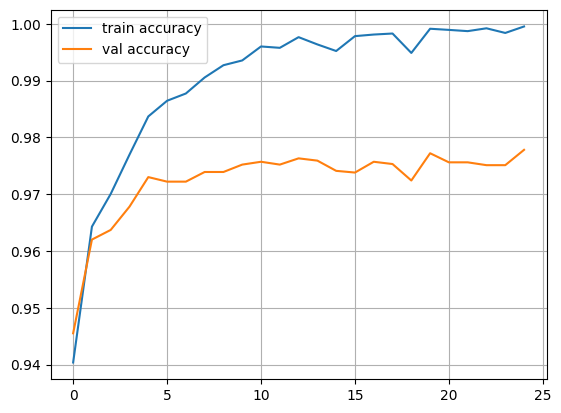

Mean epoch time (s): 0.821878


In [13]:
network = [Dense(X_train.shape[1], 100), ReLU(), Dense(100, 10)]

test_NN(network, epochs=25)

__What should you see:__ `train accuracy` should increase to near-100%. Val accuracy will also increase, allbeit to a smaller value.

__What else to try:__ You can try implementing different nonlinearities, dropout or composing neural network of more layers. See how this affects training speed, overfitting & final quality.

Good hunting!

Let us compare the results that a 3-layer network produces to those of a 5-layer network:

Epoch #24
Train accuracy: 0.9978
Val accuracy: 0.9783


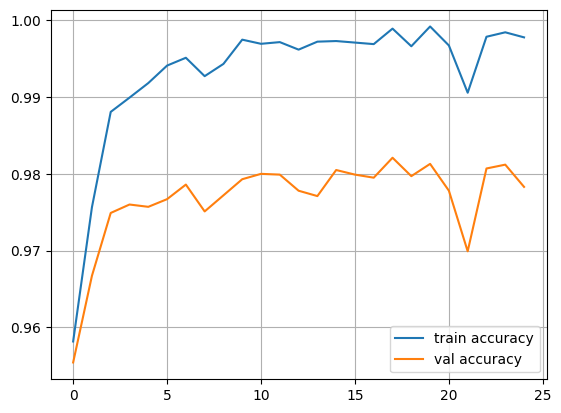

Mean epoch time (s): 11.384110


In [14]:
network_5_layers = [
    Dense(X_train.shape[1], 1000),
    ReLU(),
    Dense(1000, 100),
    ReLU(),
    Dense(100, 10),
]

test_NN(network_5_layers, epochs=25)

As indicated by the graph above, this time the network still did not achieve 100% accuracy score, however it had consistently higher accuracy score on the validation set. This came at the cost of performance as seen be mean epoch time being 13.5 times more than that of the 3-layer network.   

### Different nonlinearities

Let us try using `GELU` and `tanh` activation functions in 3-layer networks and compare the results:

In [15]:
from scipy.special import erf


def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))


class GELU(Layer):
    def __init__(self, optim: bool = False):
        """
        A GELU non-linearity layer.

        Args:
            optim: Whether to use optimized version or not. (default: False)
        """
        self.optim = optim

    def forward(self, X):
        """Apply elementwise GELU to [batch, input_units] matrix"""
        if self.optim:
            return X * sigmoid(1.702 * X)
        else:
            return X * 0.5 * (1.0 + erf(X / np.sqrt(2.0)))

    def backward(self, X, grad_output):
        """Compute gradient of loss w.r.t. GELU input"""
        if self.optim:
            return grad_output * (
                sigmoid(1.702 * X)
                + 1.702 * X * (1.0 - sigmoid(1.702 * X)) * sigmoid(1.702 * X)
            )
        else:
            erf_prime = lambda X: 2.0 / np.sqrt(np.pi) * np.exp(-(X**2))
            gelu_grad = lambda X: 0.5 * (
                np.ones_like(X)
                + X * erf_prime(X / np.sqrt(2.0)) / np.sqrt(2.0)
                + erf(X / np.sqrt(2.0))
            )
            return grad_output * gelu_grad(X)

In [16]:
from scipy.special import erf


class tanh(Layer):
    def __init__(self):
        pass

    def forward(self, X):
        """Apply elementwise tanh to [batch, input_units] matrix"""
        return np.tanh(X)

    def backward(self, X, grad_output):
        """Compute gradient of loss w.r.t. tanh input"""
        tanh_prime = lambda X: 1.0 - np.tanh(X) ** 2
        return grad_output * tanh_prime(X)

#### GELU (unoptimized)

Epoch #24
Train accuracy: 0.99938
Val accuracy: 0.9776


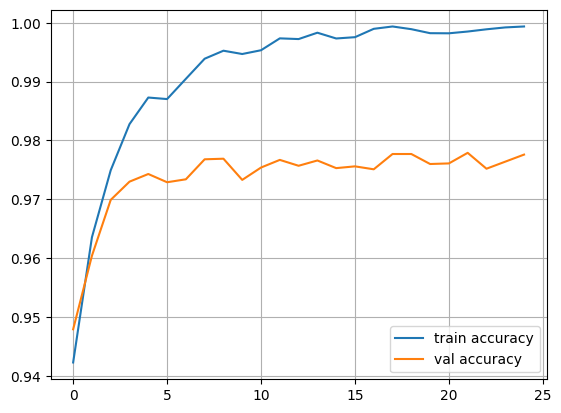

Mean epoch time (s): 0.950873


In [17]:
network = [Dense(X_train.shape[1], 100), GELU(), Dense(100, 10)]

test_NN(network, epochs=25)

#### GELU (optimized)

Epoch #24
Train accuracy: 0.99736
Val accuracy: 0.9766


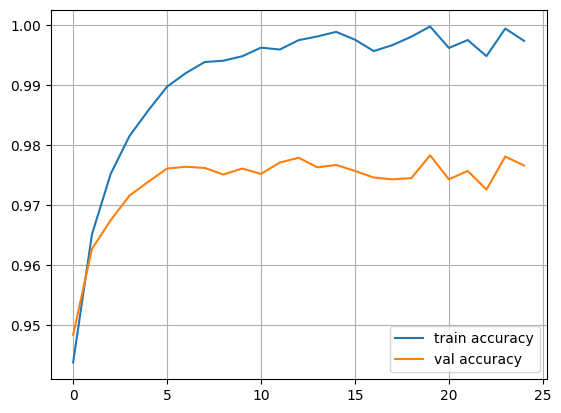

Mean epoch time (s): 0.851972


In [18]:
network = [Dense(X_train.shape[1], 100), GELU(optim=True), Dense(100, 10)]

test_NN(network, epochs=25)

#### tanh

Epoch #24
Train accuracy: 0.9999
Val accuracy: 0.9756


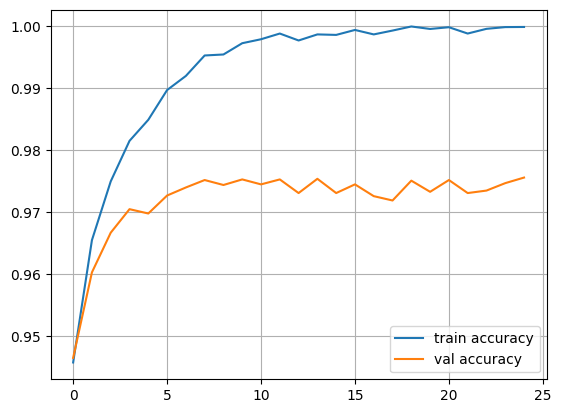

Mean epoch time (s): 0.834155


In [19]:
network = [Dense(X_train.shape[1], 100), tanh(), Dense(100, 10)]

test_NN(network, epochs=25)

After the tests, it is clear that using `GELU` yields better results than both `ReLU` and `tanh`, although it comes at the cost of performance. Using optimizations proposed in the initial `GELU` paper actually leads to results even better than those of the unoptimized version of this layer.    